In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.2))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.2))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.2))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


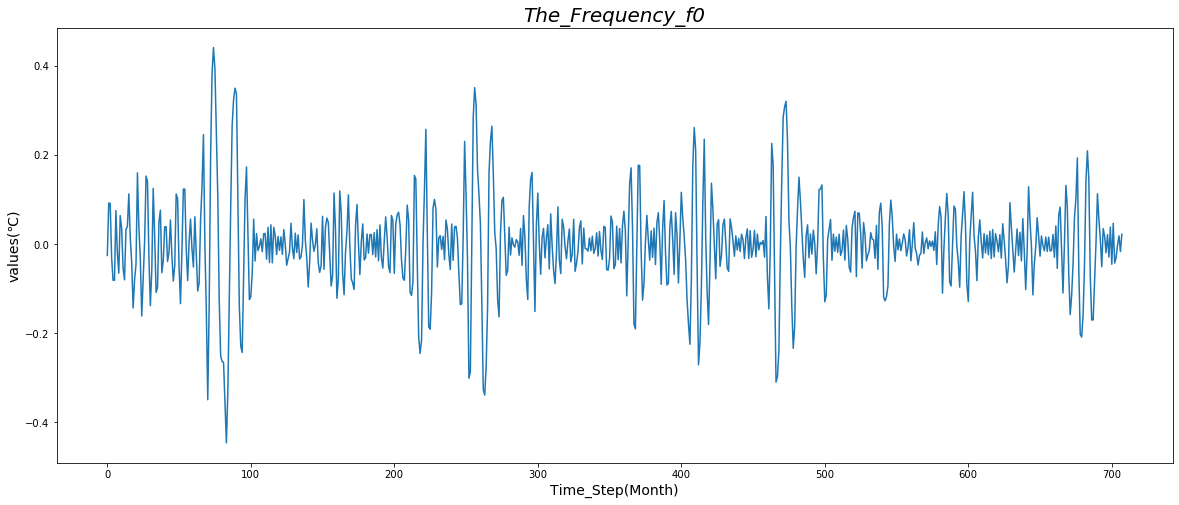

(660, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 4s - loss: 0.0110
Epoch 2/200
 - 2s - loss: 0.0110
Epoch 3/200
 - 2s - loss: 0.0109
Epoch 4/200
 - 2s - loss: 0.0109
Epoch 5/200
 - 2s - loss: 0.0109
Epoch 6/200
 - 2s - loss: 0.0109
Epoch 7/200
 - 2s - loss: 0.0109
Epoch 8/200
 - 2s - loss: 0.0109
Epoch 9/200
 - 2s - loss: 0.0109
Epoch 10/200
 - 2s - loss: 0.0108
Epoch 11/200
 - 3s - loss: 0.0107
Epoch 12/200
 - 3s - loss: 0.0106
Epoch 13/200
 - 3s - loss: 0.0103
Epoch 14/200
 - 3s - loss: 0.0102
Epoch 15/200
 - 3s - loss: 0.0102
Epoch 16/200
 - 3s - loss: 0.0106
Epoch 17/200
 - 3s - loss: 0.0098
Epoch 18/200
 - 3s - loss: 0.0097
Epoch 19/200
 - 3s - loss: 0.0095
Epoch 20/200
 - 3s - loss: 0.0093
Epoch 21/200
 - 3s - loss: 0.0095
Epoch 22/200
 - 3s - loss: 0.0092
Epoch 23/200


(56, 12)


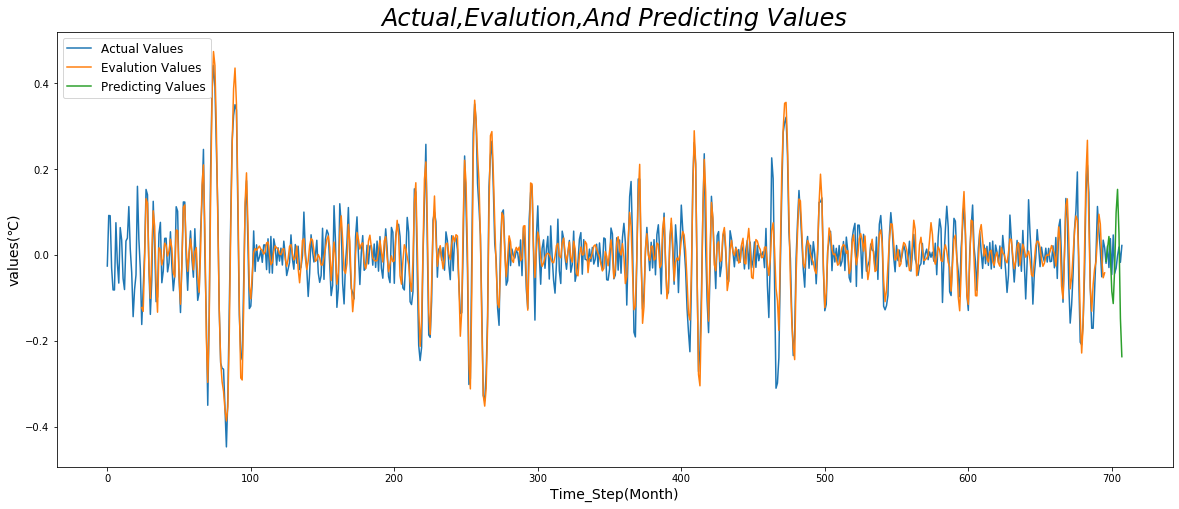

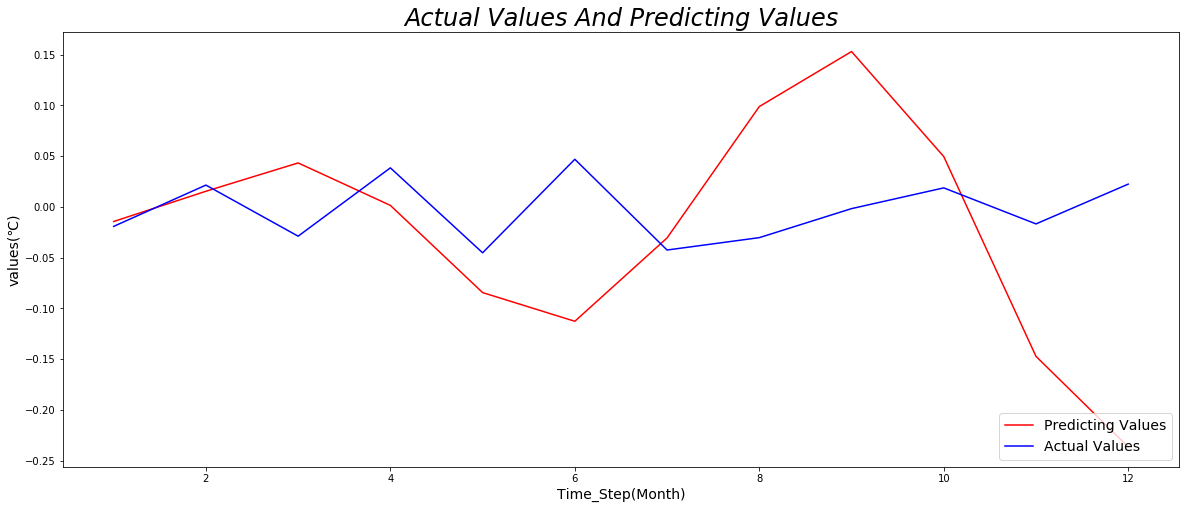

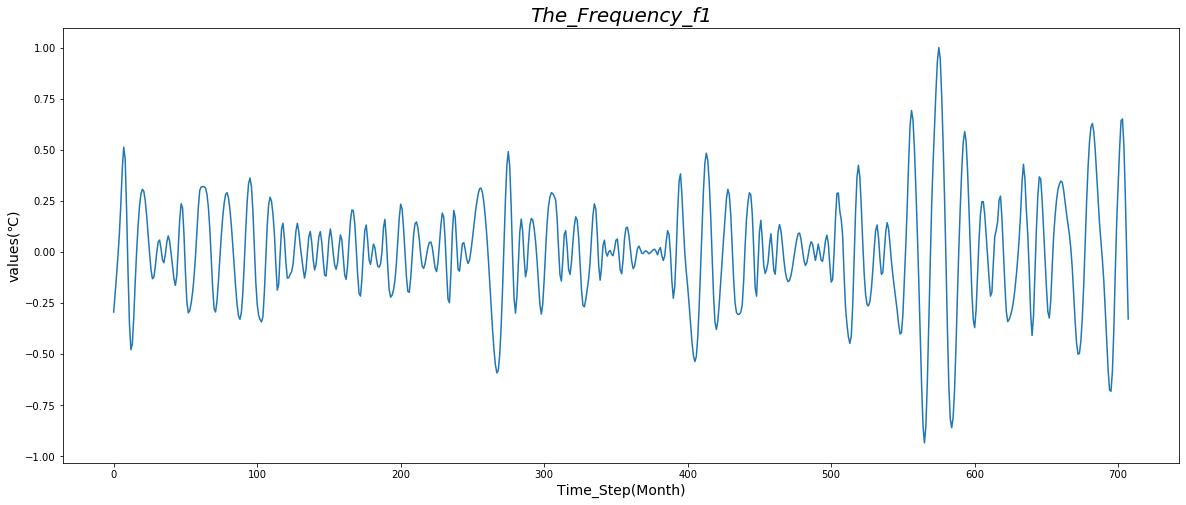

(660, 24, 1)
Epoch 1/200
 - 5s - loss: 0.0594
Epoch 2/200
 - 2s - loss: 0.0551
Epoch 3/200
 - 2s - loss: 0.0489
Epoch 4/200
 - 2s - loss: 0.0448
Epoch 5/200
 - 2s - loss: 0.0440
Epoch 6/200
 - 2s - loss: 0.0421
Epoch 7/200
 - 2s - loss: 0.0391
Epoch 8/200
 - 2s - loss: 0.0369
Epoch 9/200
 - 2s - loss: 0.0355
Epoch 10/200
 - 2s - loss: 0.0354
Epoch 11/200
 - 3s - loss: 0.0335
Epoch 12/200
 - 3s - loss: 0.0324
Epoch 13/200
 - 3s - loss: 0.0312
Epoch 14/200
 - 3s - loss: 0.0322
Epoch 15/200
 - 3s - loss: 0.0317
Epoch 16/200
 - 3s - loss: 0.0293
Epoch 17/200
 - 3s - loss: 0.0313
Epoch 18/200
 - 3s - loss: 0.0280
Epoch 19/200
 - 3s - loss: 0.0274
Epoch 20/200
 - 3s - loss: 0.0280
Epoch 21/200
 - 3s - loss: 0.0270
Epoch 22/200
 - 3s - loss: 0.0286
Epoch 23/200
 - 3s - loss: 0.0267
Epoch 24/200
 - 3s - loss: 0.0259
Epoch 25/200
 - 3s - loss: 0.0246
Epoch 26/200
 - 3s - loss: 0.0267
Epoch 27/200
 - 3s - loss: 0.0250
Epoch 28/200
 - 3s - loss: 0.0257
Epoch 29/200
 - 3s - loss: 0.0244
Epoch 30/2

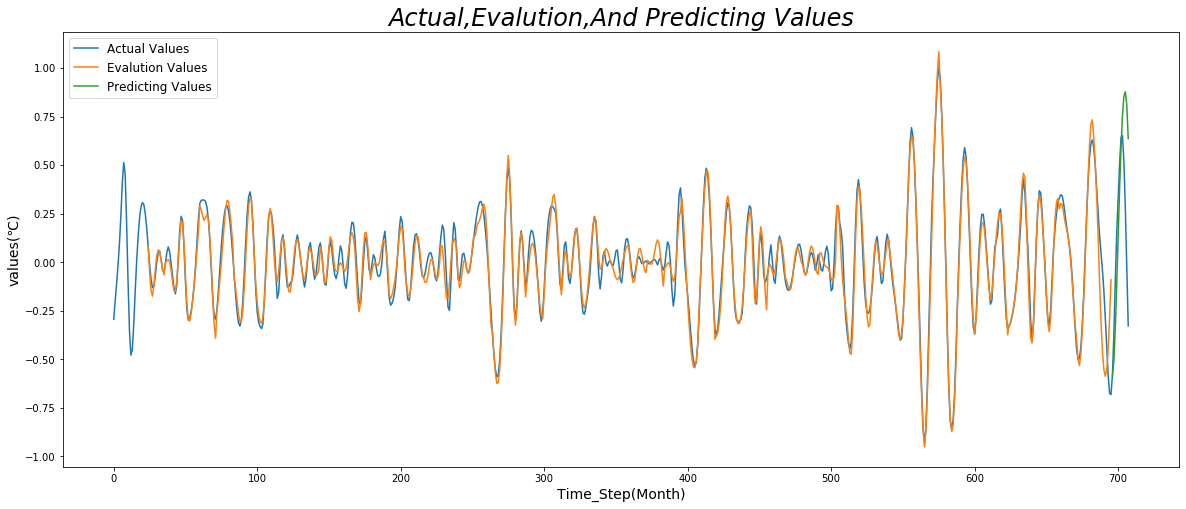

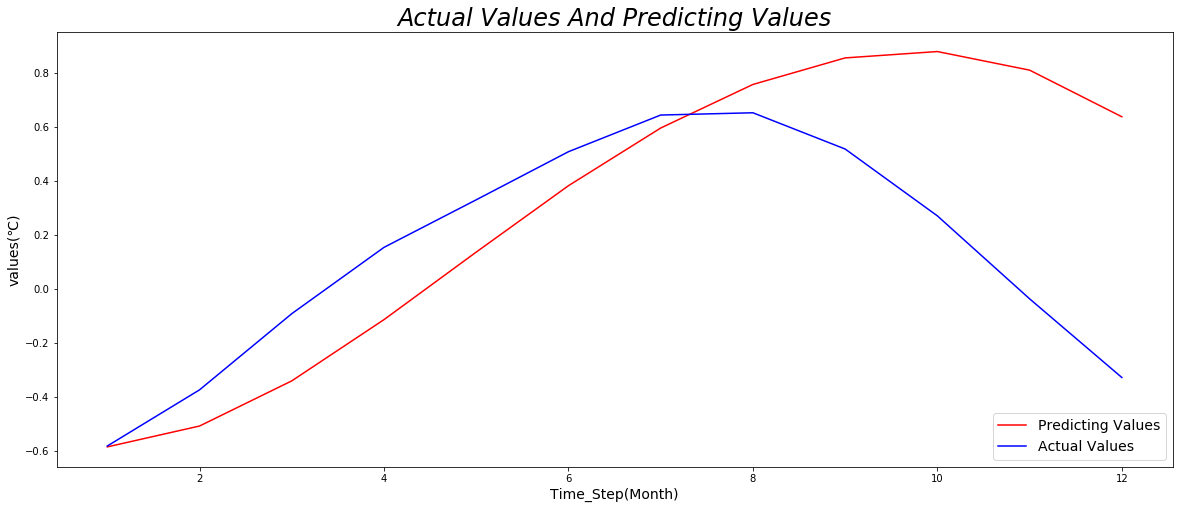

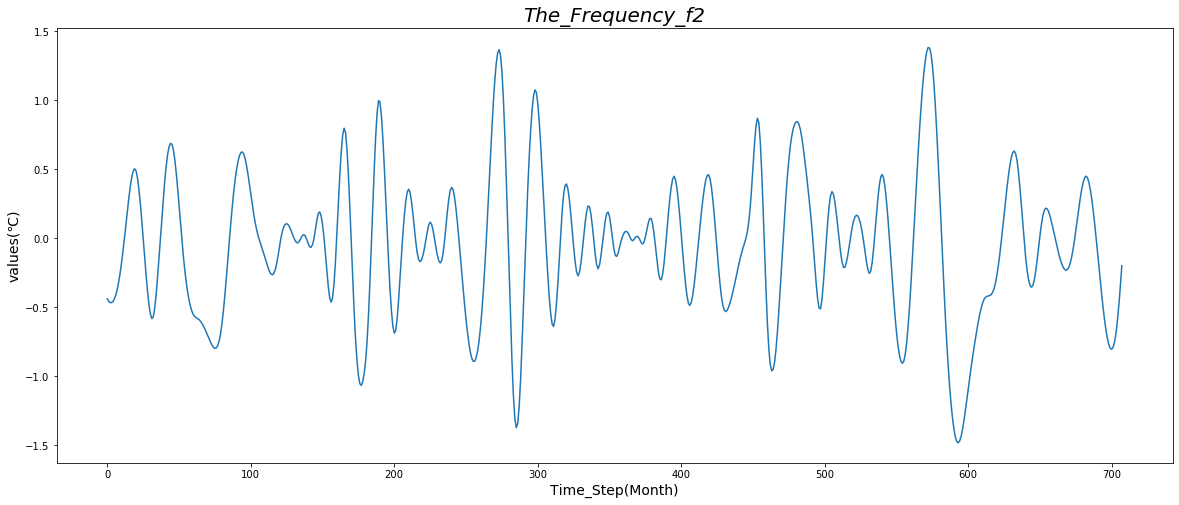

(660, 24, 1)
Epoch 1/200
 - 13s - loss: 0.2512
Epoch 2/200
 - 4s - loss: 0.2407
Epoch 3/200
 - 4s - loss: 0.2293
Epoch 4/200
 - 4s - loss: 0.1861
Epoch 5/200
 - 4s - loss: 0.1398
Epoch 6/200
 - 4s - loss: 0.1363
Epoch 7/200
 - 4s - loss: 0.1045
Epoch 8/200
 - 4s - loss: 0.0968
Epoch 9/200
 - 4s - loss: 0.0916
Epoch 10/200
 - 4s - loss: 0.0882
Epoch 11/200
 - 4s - loss: 0.0866
Epoch 12/200
 - 4s - loss: 0.0825
Epoch 13/200
 - 4s - loss: 0.0802
Epoch 14/200
 - 4s - loss: 0.0702
Epoch 15/200
 - 4s - loss: 0.0775
Epoch 16/200
 - 4s - loss: 0.0733
Epoch 17/200
 - 4s - loss: 0.0670
Epoch 18/200
 - 4s - loss: 0.0622
Epoch 19/200
 - 4s - loss: 0.0681
Epoch 20/200
 - 4s - loss: 0.0617
Epoch 21/200
 - 4s - loss: 0.0562
Epoch 22/200
 - 4s - loss: 0.0558
Epoch 23/200
 - 4s - loss: 0.0503
Epoch 24/200
 - 4s - loss: 0.0558
Epoch 25/200
 - 3s - loss: 0.0555
Epoch 26/200
 - 3s - loss: 0.0593
Epoch 27/200
 - 3s - loss: 0.0524
Epoch 28/200
 - 3s - loss: 0.0470
Epoch 29/200
 - 3s - loss: 0.0451
Epoch 30/

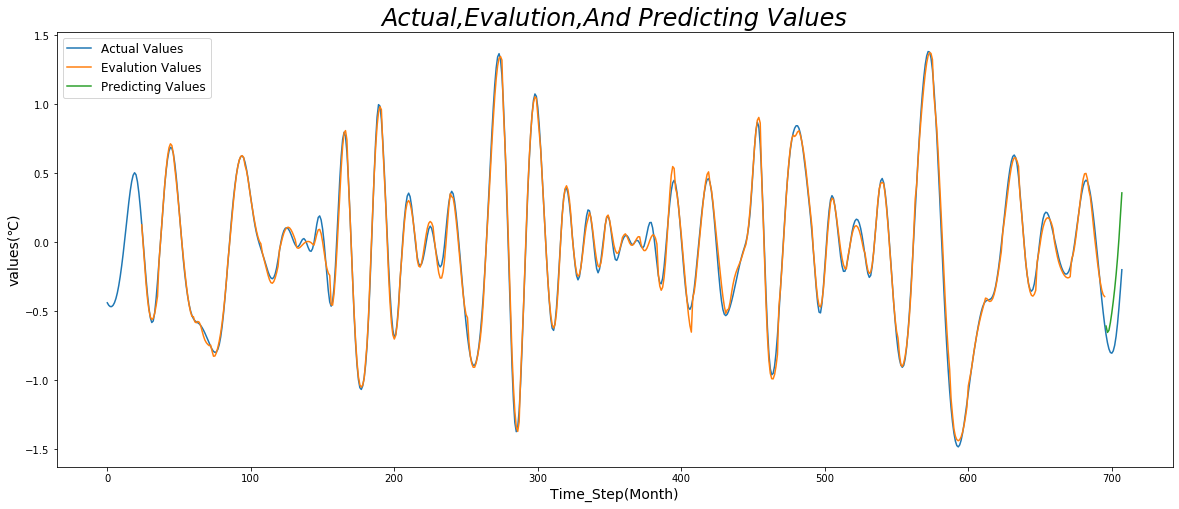

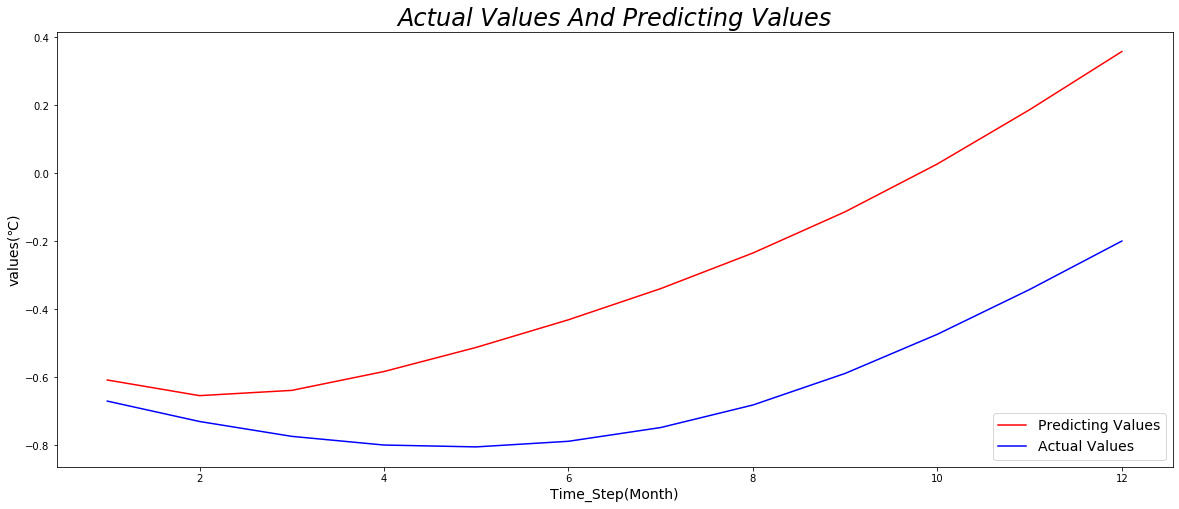

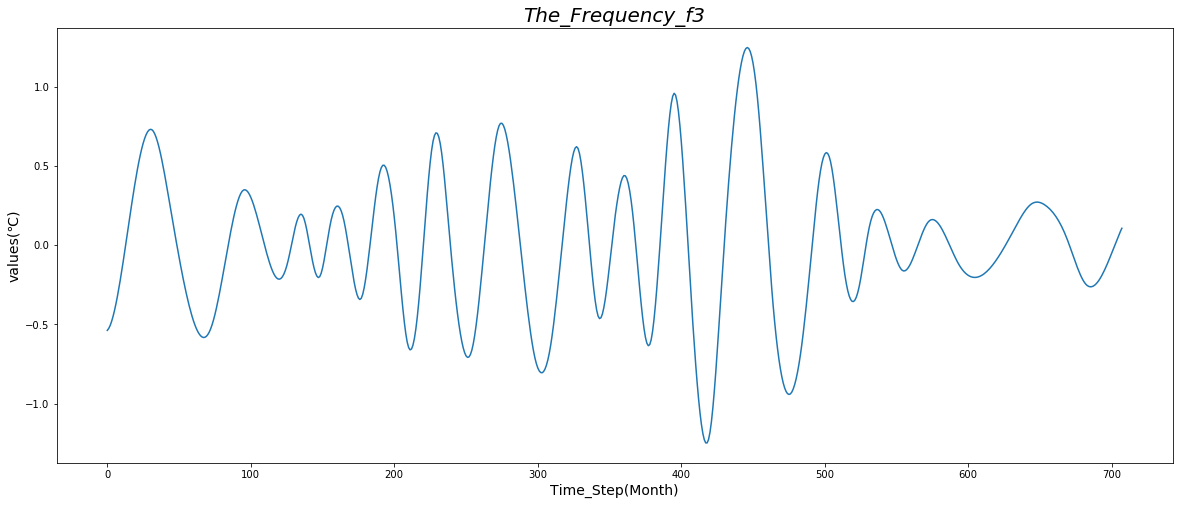

(660, 24, 1)
Epoch 1/200
 - 13s - loss: 0.1672
Epoch 2/200
 - 5s - loss: 0.1280
Epoch 3/200
 - 5s - loss: 0.0896
Epoch 4/200
 - 5s - loss: 0.0656
Epoch 5/200
 - 5s - loss: 0.0471
Epoch 6/200
 - 5s - loss: 0.0426
Epoch 7/200
 - 5s - loss: 0.0421
Epoch 8/200
 - 5s - loss: 0.0290
Epoch 9/200
 - 5s - loss: 0.0265
Epoch 10/200
 - 4s - loss: 0.0268
Epoch 11/200
 - 3s - loss: 0.0180
Epoch 12/200
 - 3s - loss: 0.0234
Epoch 13/200
 - 3s - loss: 0.0194
Epoch 14/200
 - 3s - loss: 0.0151
Epoch 15/200
 - 3s - loss: 0.0152
Epoch 16/200
 - 4s - loss: 0.0124
Epoch 17/200
 - 5s - loss: 0.0140
Epoch 18/200
 - 4s - loss: 0.0134
Epoch 19/200
 - 4s - loss: 0.0111
Epoch 20/200
 - 4s - loss: 0.0126
Epoch 21/200
 - 4s - loss: 0.0118
Epoch 22/200
 - 4s - loss: 0.0121
Epoch 23/200
 - 4s - loss: 0.0137
Epoch 24/200
 - 4s - loss: 0.0127
Epoch 25/200
 - 4s - loss: 0.0111
Epoch 26/200
 - 4s - loss: 0.0156
Epoch 27/200
 - 4s - loss: 0.0188
Epoch 28/200
 - 4s - loss: 0.0131
Epoch 29/200
 - 4s - loss: 0.0132
Epoch 30/

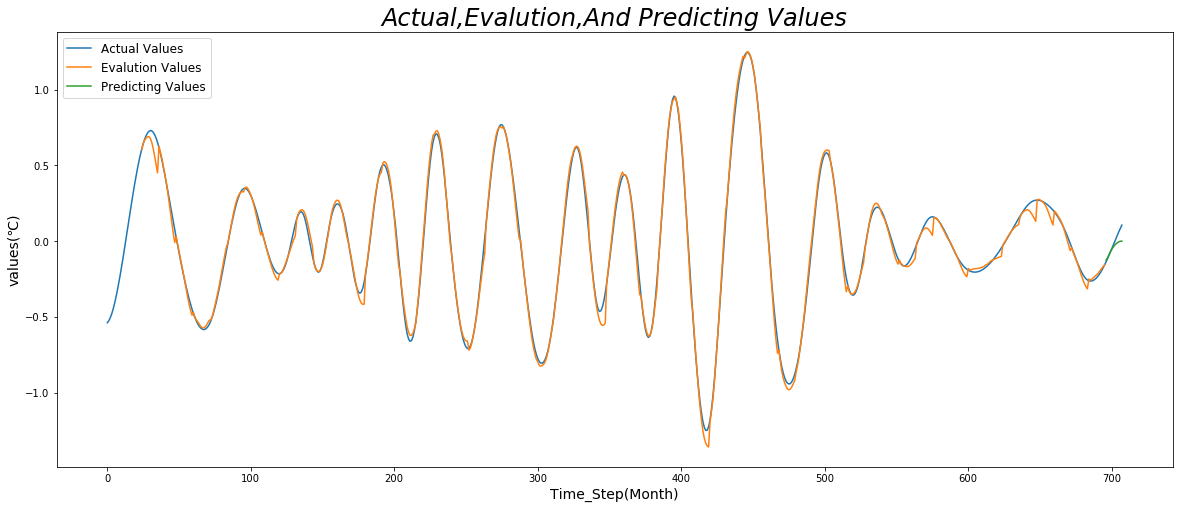

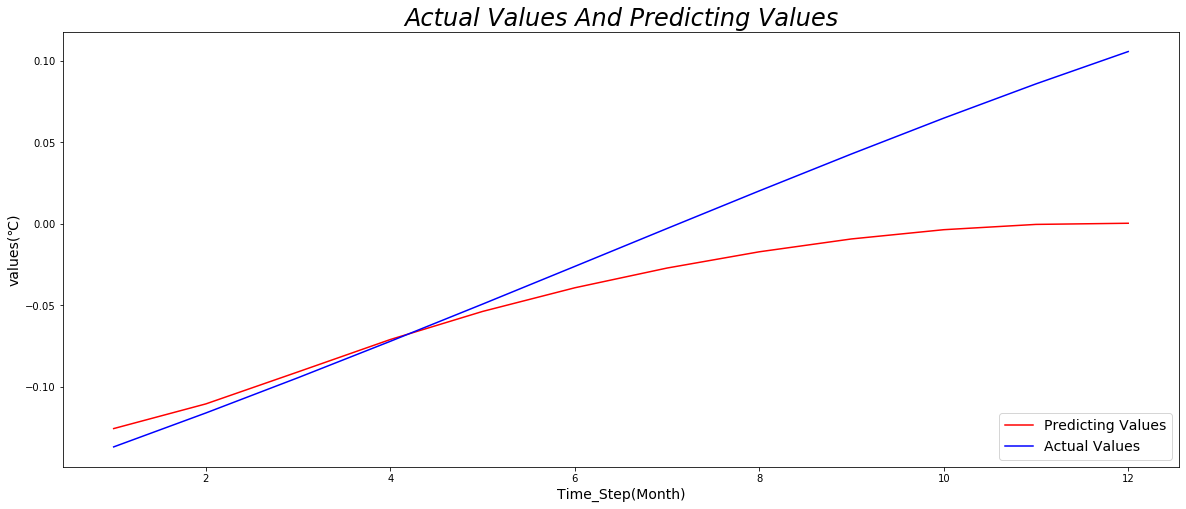

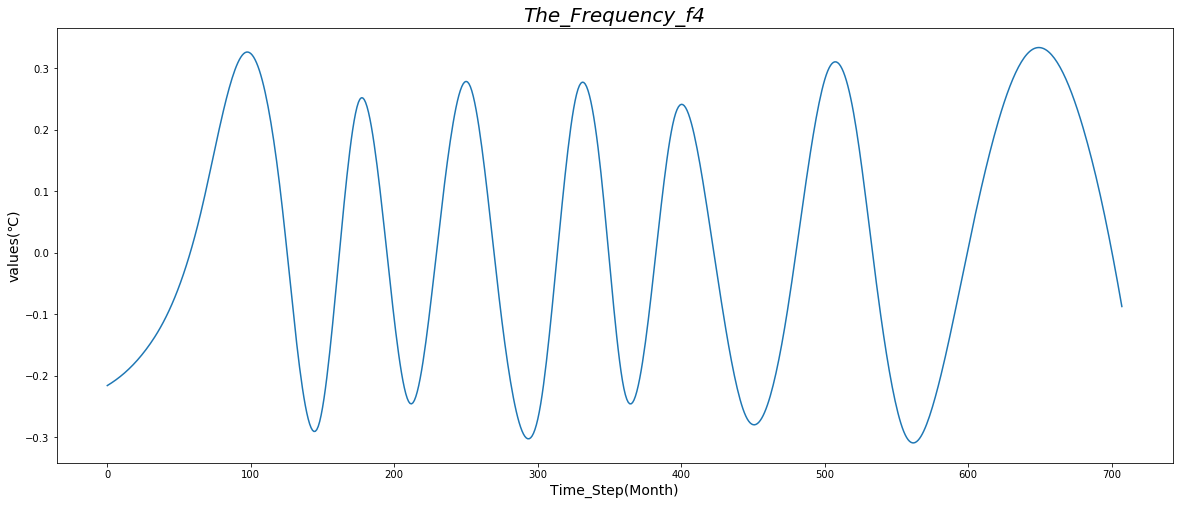

(660, 24, 1)
Epoch 1/200
 - 12s - loss: 0.0303
Epoch 2/200
 - 4s - loss: 0.0113
Epoch 3/200
 - 3s - loss: 0.0063
Epoch 4/200
 - 3s - loss: 0.0044
Epoch 5/200
 - 3s - loss: 0.0031
Epoch 6/200
 - 3s - loss: 0.0022
Epoch 7/200
 - 4s - loss: 0.0018
Epoch 8/200
 - 5s - loss: 0.0013
Epoch 9/200
 - 5s - loss: 0.0017
Epoch 10/200
 - 5s - loss: 0.0013
Epoch 11/200
 - 5s - loss: 0.0015
Epoch 12/200
 - 5s - loss: 0.0012
Epoch 13/200
 - 5s - loss: 9.9248e-04
Epoch 14/200
 - 5s - loss: 8.9930e-04
Epoch 15/200
 - 5s - loss: 8.4576e-04
Epoch 16/200
 - 5s - loss: 9.2668e-04
Epoch 17/200
 - 5s - loss: 7.6310e-04
Epoch 18/200
 - 5s - loss: 6.9675e-04
Epoch 19/200
 - 5s - loss: 9.2997e-04
Epoch 20/200
 - 5s - loss: 7.6080e-04
Epoch 21/200
 - 5s - loss: 7.8766e-04
Epoch 22/200
 - 5s - loss: 7.5272e-04
Epoch 23/200
 - 5s - loss: 8.0093e-04
Epoch 24/200
 - 5s - loss: 7.2351e-04
Epoch 25/200
 - 5s - loss: 8.0507e-04
Epoch 26/200
 - 5s - loss: 6.9397e-04
Epoch 27/200
 - 5s - loss: 6.9712e-04
Epoch 28/200
 - 5

(56, 12)


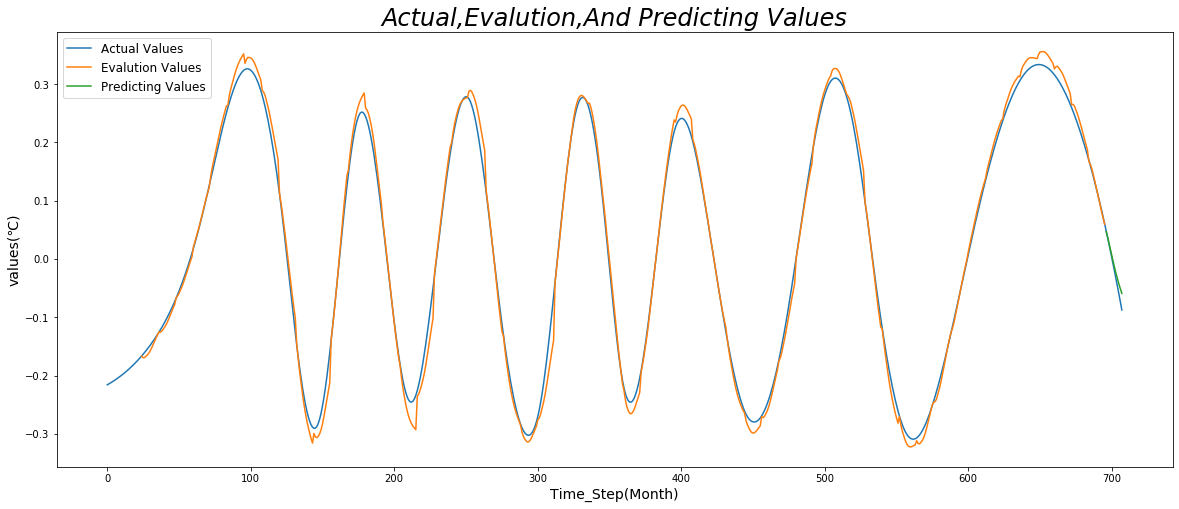

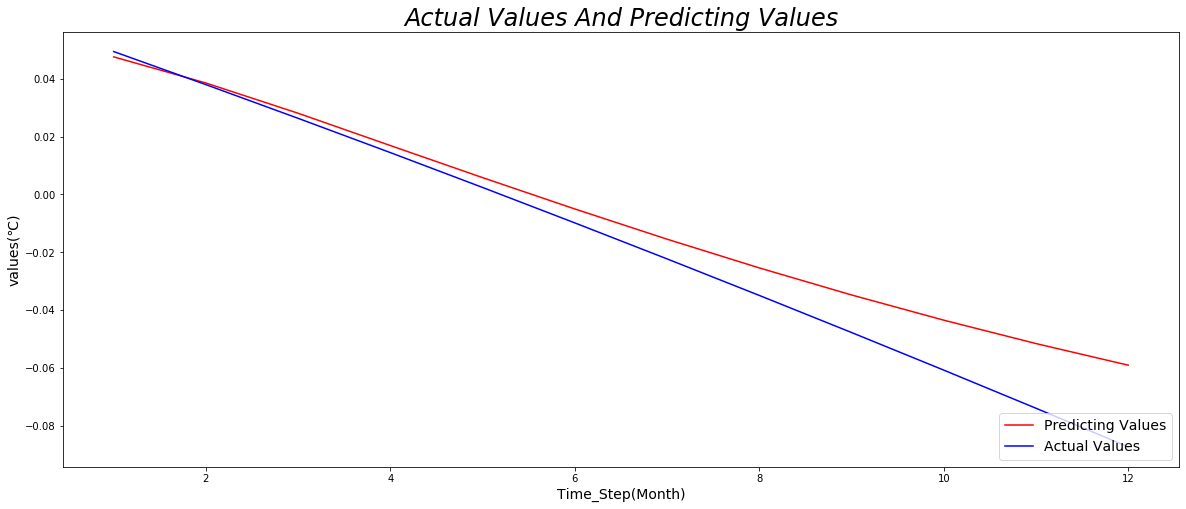

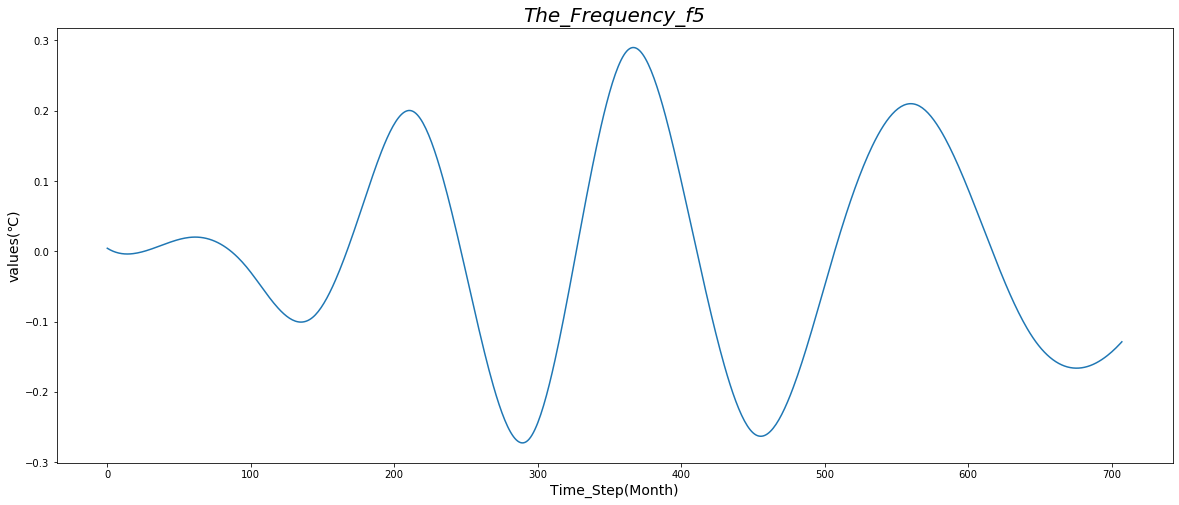

(660, 24, 1)
Epoch 1/200
 - 12s - loss: 0.0157
Epoch 2/200
 - 4s - loss: 0.0074
Epoch 3/200
 - 4s - loss: 0.0025
Epoch 4/200
 - 4s - loss: 8.9671e-04
Epoch 5/200
 - 3s - loss: 4.5917e-04
Epoch 6/200
 - 4s - loss: 2.9253e-04
Epoch 7/200
 - 5s - loss: 2.3994e-04
Epoch 8/200
 - 5s - loss: 1.9841e-04
Epoch 9/200
 - 5s - loss: 1.9903e-04
Epoch 10/200
 - 5s - loss: 1.8601e-04
Epoch 11/200
 - 5s - loss: 2.3009e-04
Epoch 12/200
 - 5s - loss: 4.0038e-04
Epoch 13/200
 - 5s - loss: 2.6409e-04
Epoch 14/200
 - 5s - loss: 1.6508e-04
Epoch 15/200
 - 5s - loss: 1.5572e-04
Epoch 16/200
 - 5s - loss: 2.0099e-04
Epoch 17/200
 - 5s - loss: 1.9498e-04
Epoch 18/200
 - 5s - loss: 1.7546e-04
Epoch 19/200
 - 5s - loss: 1.7485e-04
Epoch 20/200
 - 5s - loss: 2.0346e-04
Epoch 21/200
 - 5s - loss: 1.5351e-04
Epoch 22/200
 - 5s - loss: 1.3395e-04
Epoch 23/200
 - 5s - loss: 2.7541e-04
Epoch 24/200
 - 5s - loss: 2.2354e-04
Epoch 25/200
 - 5s - loss: 2.2073e-04
Epoch 26/200
 - 5s - loss: 1.9184e-04
Epoch 27/200
 - 5s 

(56, 12)


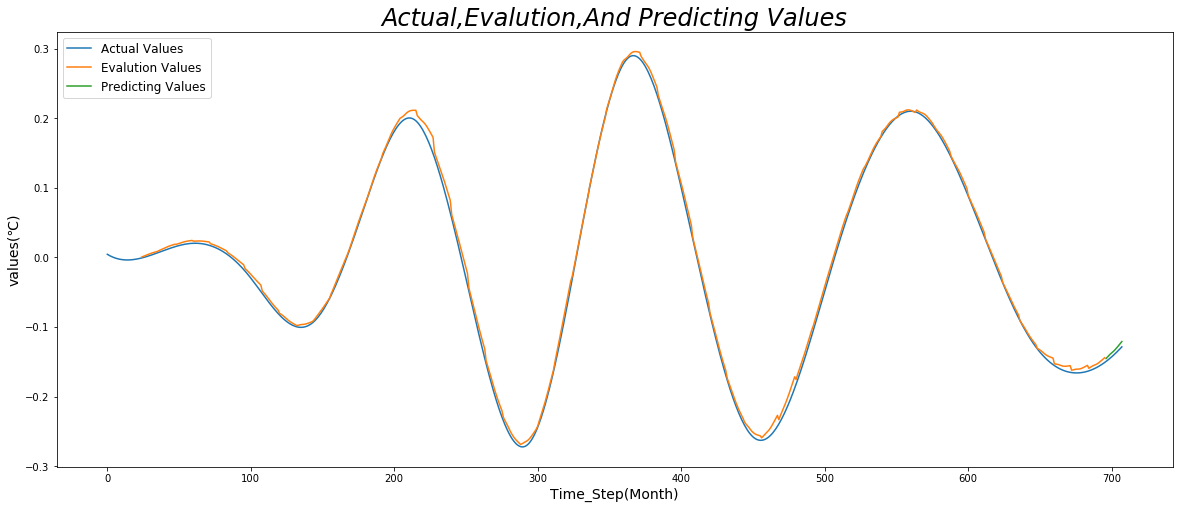

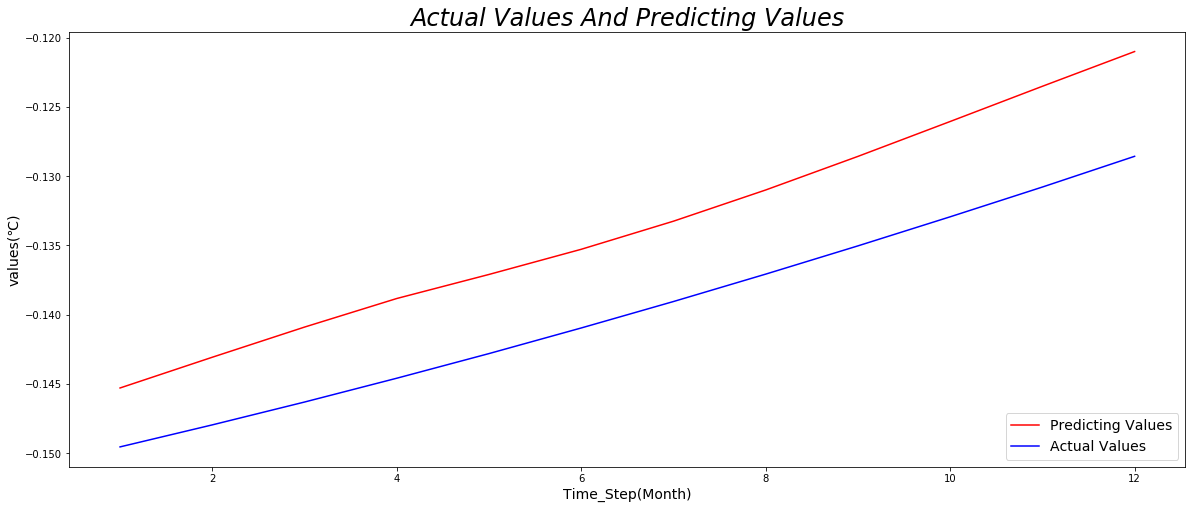

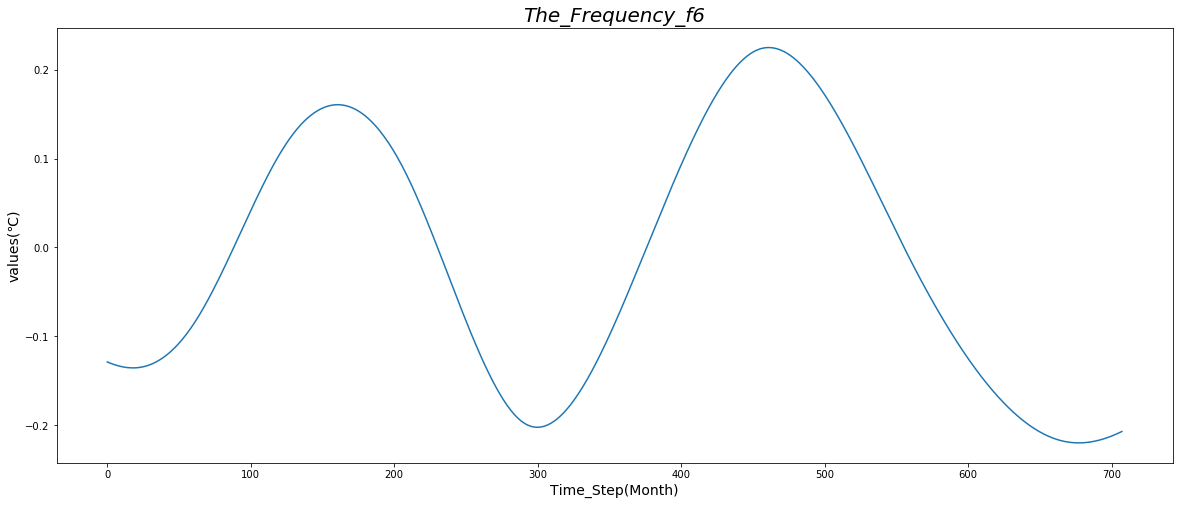

(660, 24, 1)
Epoch 1/200
 - 13s - loss: 0.0088
Epoch 2/200
 - 6s - loss: 0.0038
Epoch 3/200
 - 6s - loss: 0.0021
Epoch 4/200
 - 6s - loss: 9.5999e-04
Epoch 5/200
 - 6s - loss: 3.5355e-04
Epoch 6/200
 - 6s - loss: 1.9319e-04
Epoch 7/200
 - 6s - loss: 1.5535e-04
Epoch 8/200
 - 6s - loss: 1.3243e-04
Epoch 9/200
 - 6s - loss: 1.1356e-04
Epoch 10/200
 - 6s - loss: 1.2100e-04
Epoch 11/200
 - 6s - loss: 1.3098e-04
Epoch 12/200
 - 6s - loss: 1.4044e-04
Epoch 13/200
 - 6s - loss: 9.2752e-05
Epoch 14/200
 - 6s - loss: 1.1351e-04
Epoch 15/200
 - 6s - loss: 8.8197e-05
Epoch 16/200
 - 6s - loss: 1.1990e-04
Epoch 17/200
 - 6s - loss: 1.2645e-04
Epoch 18/200
 - 6s - loss: 1.1407e-04
Epoch 19/200
 - 6s - loss: 1.3374e-04
Epoch 20/200
 - 6s - loss: 9.7376e-05
Epoch 21/200
 - 6s - loss: 9.3462e-05
Epoch 22/200
 - 5s - loss: 7.0481e-05
Epoch 23/200
 - 4s - loss: 7.2701e-05
Epoch 24/200
 - 4s - loss: 9.9363e-05
Epoch 25/200
 - 4s - loss: 1.0788e-04
Epoch 26/200
 - 4s - loss: 8.3233e-05
Epoch 27/200
 - 5s 

(56, 12)


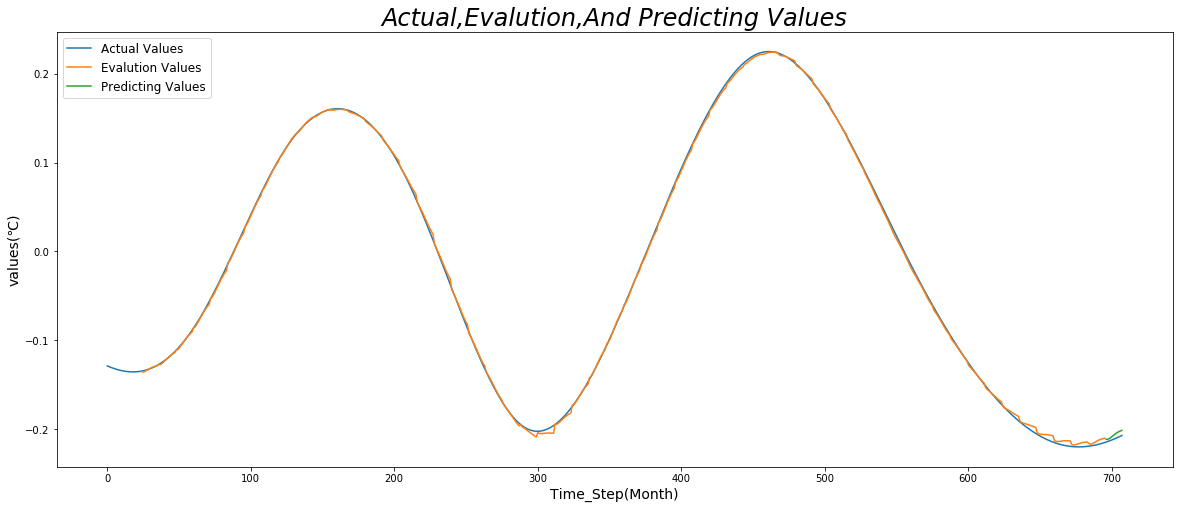

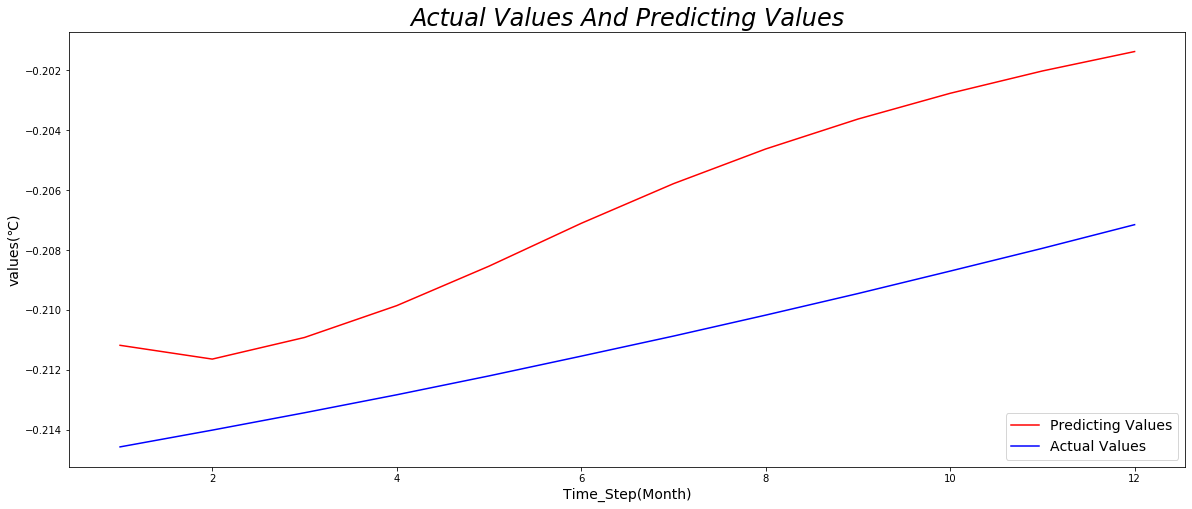

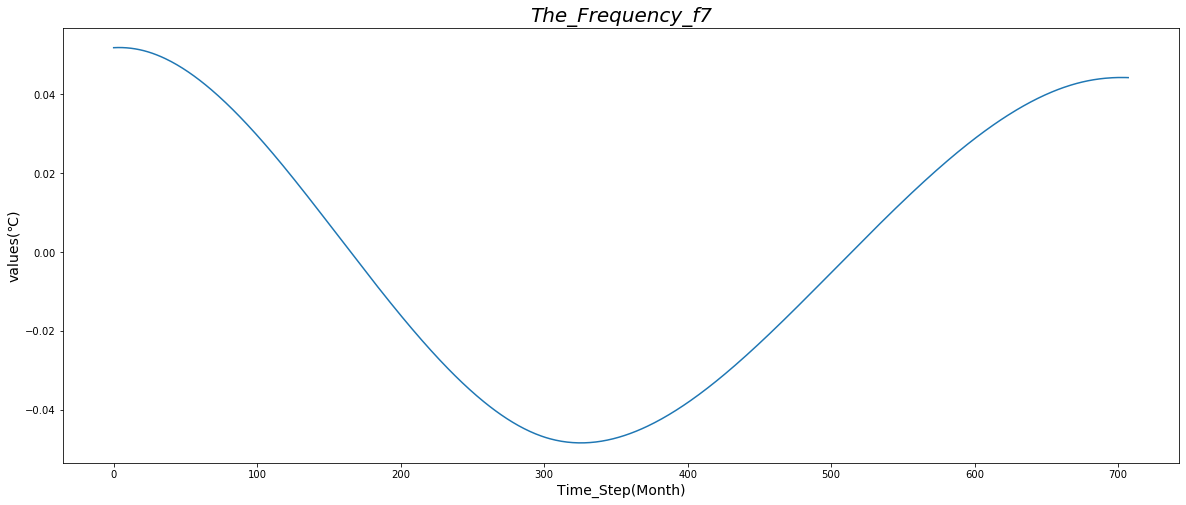

(660, 24, 1)
Epoch 1/200
 - 13s - loss: 9.8079e-04
Epoch 2/200
 - 6s - loss: 2.6629e-04
Epoch 3/200
 - 6s - loss: 1.4297e-04
Epoch 4/200
 - 6s - loss: 9.3916e-05
Epoch 5/200
 - 6s - loss: 7.2359e-05
Epoch 6/200
 - 6s - loss: 5.8449e-05
Epoch 7/200
 - 6s - loss: 4.8958e-05
Epoch 8/200
 - 6s - loss: 4.3226e-05
Epoch 9/200
 - 6s - loss: 4.1179e-05
Epoch 10/200
 - 6s - loss: 3.9697e-05
Epoch 11/200
 - 6s - loss: 3.6705e-05
Epoch 12/200
 - 6s - loss: 2.8350e-05
Epoch 13/200
 - 6s - loss: 2.3271e-05
Epoch 14/200
 - 6s - loss: 2.5208e-05
Epoch 15/200
 - 6s - loss: 1.8111e-05
Epoch 16/200
 - 6s - loss: 1.4991e-05
Epoch 17/200
 - 6s - loss: 1.1029e-05
Epoch 18/200
 - 6s - loss: 1.5031e-05
Epoch 19/200
 - 6s - loss: 1.1241e-05
Epoch 20/200
 - 6s - loss: 9.2793e-06
Epoch 21/200
 - 7s - loss: 7.1842e-06
Epoch 22/200
 - 6s - loss: 9.8636e-06
Epoch 23/200
 - 6s - loss: 7.4934e-06
Epoch 24/200
 - 6s - loss: 6.2616e-06
Epoch 25/200
 - 6s - loss: 5.1883e-06
Epoch 26/200
 - 6s - loss: 5.7358e-06
Epoch 2

(56, 12)


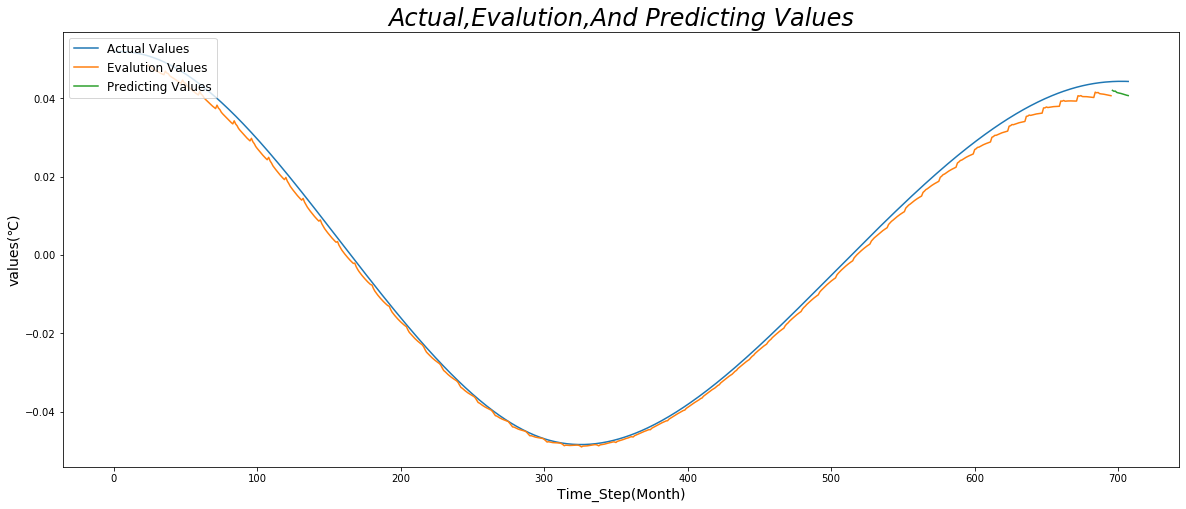

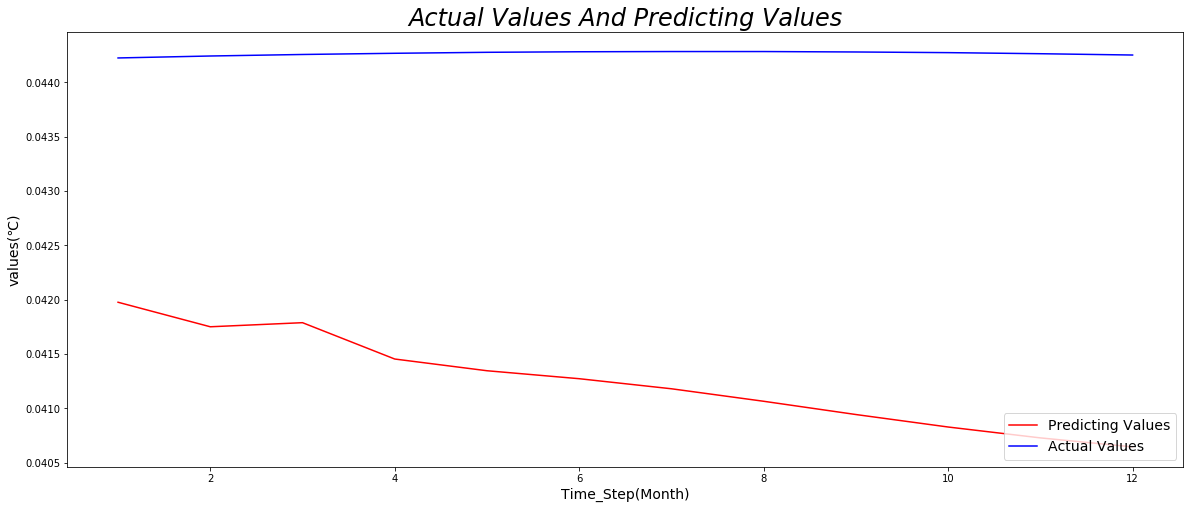

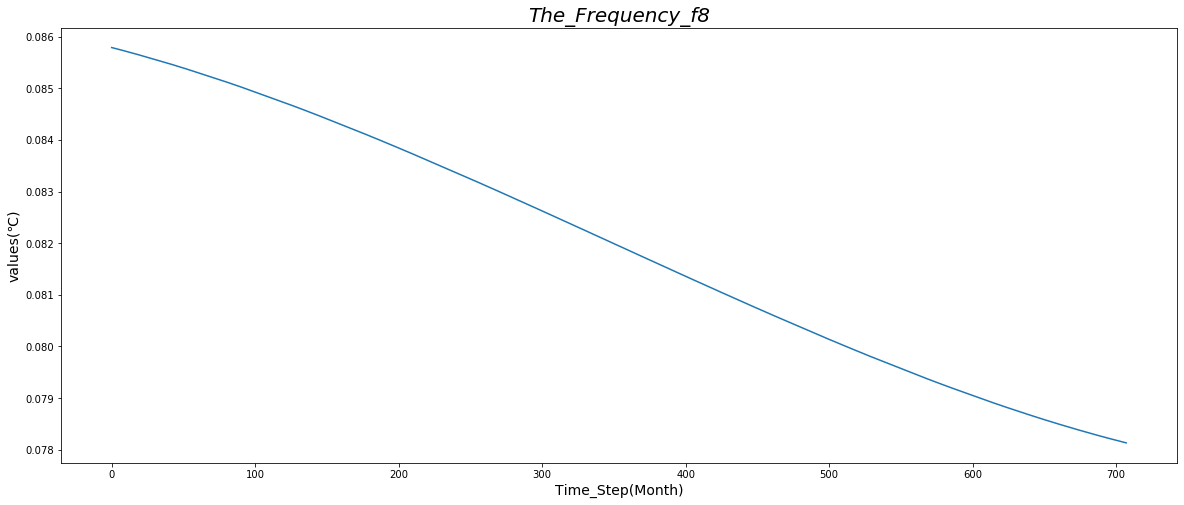

(660, 24, 1)
Epoch 1/200
 - 14s - loss: 6.3265e-04
Epoch 2/200
 - 6s - loss: 1.6085e-05
Epoch 3/200
 - 6s - loss: 6.6817e-06
Epoch 4/200
 - 6s - loss: 6.2075e-06
Epoch 5/200
 - 6s - loss: 6.0118e-06
Epoch 6/200
 - 6s - loss: 5.8343e-06
Epoch 7/200
 - 6s - loss: 5.6757e-06
Epoch 8/200
 - 6s - loss: 5.4721e-06
Epoch 9/200
 - 6s - loss: 5.5953e-06
Epoch 10/200
 - 6s - loss: 5.5261e-06
Epoch 11/200
 - 6s - loss: 6.0963e-06
Epoch 12/200
 - 6s - loss: 5.5211e-06
Epoch 13/200
 - 6s - loss: 5.4920e-06
Epoch 14/200
 - 6s - loss: 5.2615e-06
Epoch 15/200
 - 6s - loss: 5.2519e-06
Epoch 16/200
 - 6s - loss: 5.5001e-06
Epoch 17/200
 - 6s - loss: 5.1873e-06
Epoch 18/200
 - 6s - loss: 5.2033e-06
Epoch 19/200
 - 6s - loss: 5.1974e-06
Epoch 20/200
 - 6s - loss: 5.6304e-06
Epoch 21/200
 - 6s - loss: 5.1205e-06
Epoch 22/200
 - 6s - loss: 5.3149e-06
Epoch 23/200
 - 6s - loss: 5.3492e-06
Epoch 24/200
 - 6s - loss: 5.2320e-06
Epoch 25/200
 - 6s - loss: 5.7095e-06
Epoch 26/200
 - 6s - loss: 5.1220e-06
Epoch 2

(56, 12)


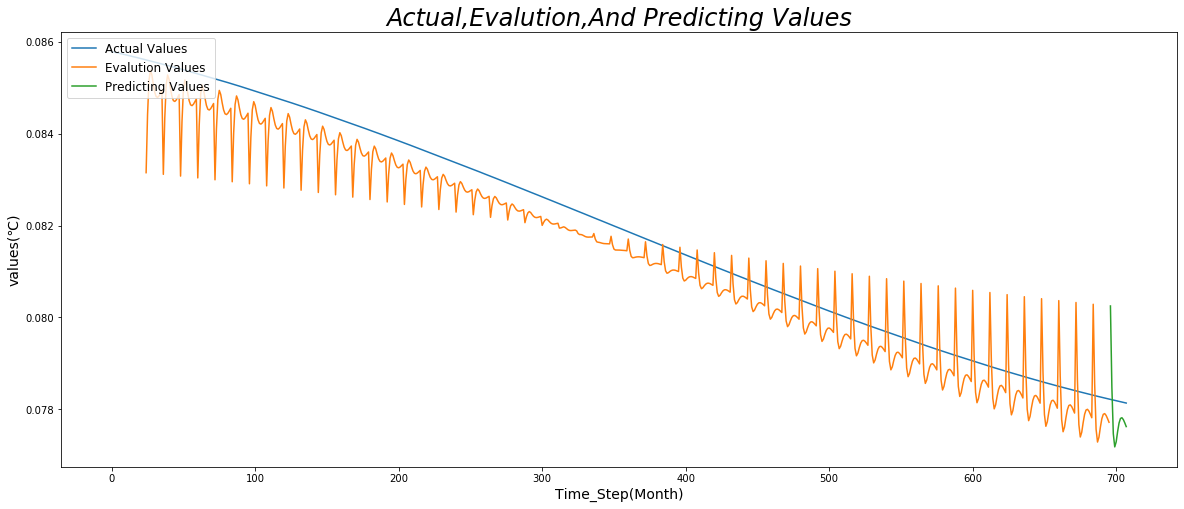

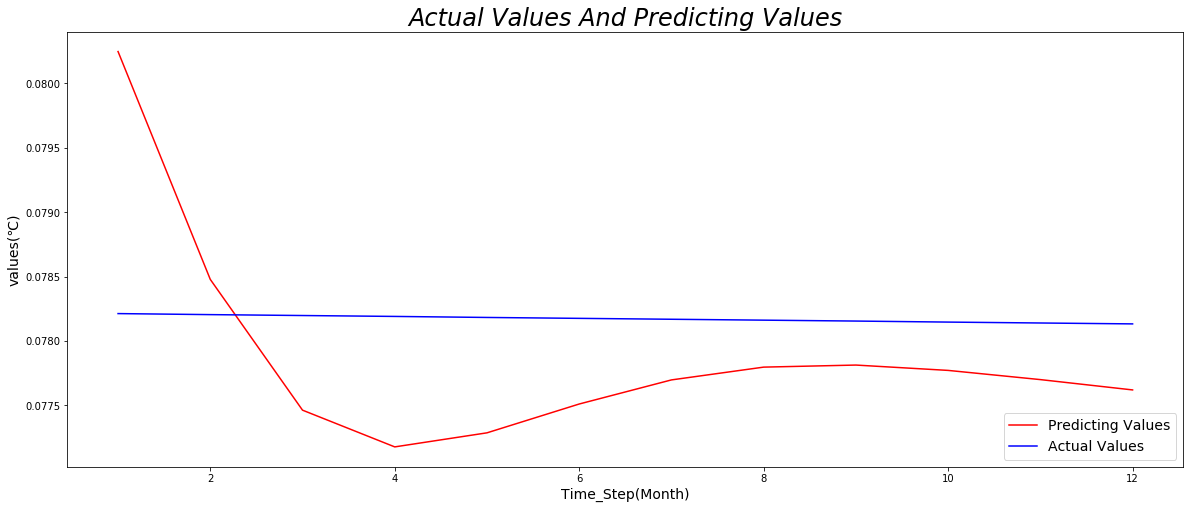

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-120]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08024726]
 [0.07847754]
 [0.07746199]
 [0.07717668]
 [0.07728585]
 [0.07750977]
 [0.0776969 ]
 [0.07779623]
 [0.07781224]
 [0.07777075]
 [0.07769931]
 [0.07761913]]
[array([-0.019294 ,  0.021388 , -0.028952 ,  0.038371 , -0.045308 ,
        0.046826 , -0.042584 , -0.030396 , -0.0018028,  0.018636 ,
       -0.016862 ,  0.022332 ]), array([-0.58173 , -0.37399 , -0.092222,  0.15317 ,  0.32912 ,  0.50709 ,
        0.64271 ,  0.65109 ,  0.517   ,  0.26965 , -0.037233, -0.32834 ]), array([-0.66973, -0.72969, -0.77339, -0.79891, -0.80437, -0.78789,
       -0.74749, -0.6812 , -0.5883 , -0.4732 , -0.34158, -0.19912]), array([-0.13697  , -0.11613  , -0.094459 , -0.072128 , -0.049296 ,
       -0.02613  , -0.0028679,  0.020229 ,  0.042903 ,  0.064891 ,
        0.085936 ,  0.10578  ]), array([ 0.049402 ,  0.037958 ,  0.026307 ,  0.014453 ,  0.0023977,
       -0.0098541, -0.0223   , -0.034936 , -0.047759 , -0.060765 ,
       -0.073953 , -0.087317 ]), array([-0.14955, -0.14796, -0.14631, -0.14459

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.019294   0.021388  -0.028952   0.038371  -0.045308   0.046826
 -0.042584  -0.030396  -0.0018028  0.018636  -0.016862   0.022332 ]
[[-0.019294 ]
 [ 0.021388 ]
 [-0.028952 ]
 [ 0.038371 ]
 [-0.045308 ]
 [ 0.046826 ]
 [-0.042584 ]
 [-0.030396 ]
 [-0.0018028]
 [ 0.018636 ]
 [-0.016862 ]
 [ 0.022332 ]]
[[-0.02]
 [ 0.02]
 [-0.03]
 [ 0.04]
 [-0.05]
 [ 0.05]
 [-0.04]
 [-0.03]
 [-0.  ]
 [ 0.02]
 [-0.02]
 [ 0.02]]
-----------------------------------
observe value:[-0.58173  -0.37399  -0.092222  0.15317   0.32912   0.50709   0.64271
  0.65109   0.517     0.26965  -0.037233 -0.32834 ]
[[-0.601024 ]
 [-0.352602 ]
 [-0.121174 ]
 [ 0.191541 ]
 [ 0.283812 ]
 [ 0.553916 ]
 [ 0.600126 ]
 [ 0.620694 ]
 [ 0.5151972]
 [ 0.288286 ]
 [-0.054095 ]
 [-0.306008 ]]
[[-0.6 ]
 [-0.35]
 [-0.12]
 [ 0.19]
 [ 0.28]
 [ 0.55]
 [ 0.6 ]
 [ 0.62]
 [ 0.52]
 [ 0.29]
 [-0.05]
 [-0.31]]
-----------------------------------
observe value:[-0.66973 -0.72969 -0.77339 -0.79891 -0.80437 -0.78789 -0.74749 -0.6812
 -

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.01449242  0.01530686  0.04322049  0.00138957 -0.08452491 -0.11280293
 -0.03067169  0.09875246  0.15295708  0.0494767  -0.14734203 -0.23654959]
[-0.01449242  0.01530686  0.04322049  0.00138957 -0.08452491 -0.11280293
 -0.03067169  0.09875246  0.15295708  0.0494767  -0.14734203 -0.23654959]
the 1 frequence:
predicted_value:[-0.58501273 -0.5078344  -0.3407742  -0.11420359  0.1356688   0.3812506
  0.59467685  0.75585806  0.854066    0.87760925  0.8087871   0.63635445]
[-0.59950515 -0.49252751 -0.29755372 -0.11281402  0.05114388  0.26844766
  0.56400516  0.85461053  1.0070231   0.92708595  0.66144508  0.39980486]
the 2 frequence:
predicted_value:[-0.6076527  -0.65366197 -0.63821125 -0.58276546 -0.5118006  -0.4305897
 -0.3389689  -0.23429357 -0.11304551  0.0276089   0.18712184  0.35811368]
[-1.20715788 -1.14618948 -0.93576497 -0.69557948 -0.4606567  -0.16214205
  0.22503626  0.62031696  0.89397758  0.95469485  0.84856

[[-1.6]
 [-1.4]
 [-1.2]
 [-0.9]
 [-0.8]
 [-0.5]
 [-0.4]
 [-0.3]
 [-0.3]
 [-0.4]
 [-0.6]
 [-0.7]]
[-1.51957282 -1.45271322 -1.23115263 -0.97977128 -0.73564802 -0.43005216
 -0.03775334  0.36096873  0.63649024  0.69737962  0.58953196  0.49511445]


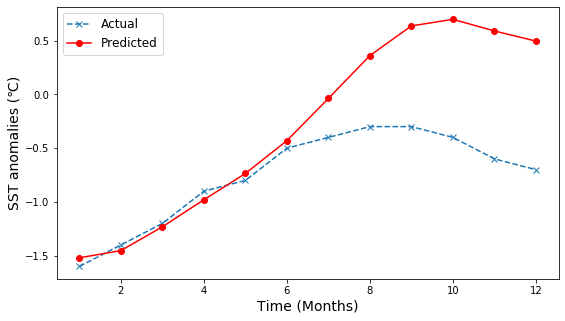

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 


In [4]:
predicted_values=[-1.51957282,-1.45271322,-1.23115263,-0.97977128,-0.73564802,-0.43005216,-0.03775334,0.36096873,0.63649024,0.69737962,0.58953196,0.49511445]

print ("----------predicted values covert with , ----------")
converted_values=",".join(str(round(round_predicted,2)) for round_predicted in predicted_values)
print ("[{0}]".format(converted_values))
print ("---------------------------------------------------")

----------predicted values covert with , ----------
[-1.52,-1.45,-1.23,-0.98,-0.74,-0.43,-0.04,0.36,0.64,0.7,0.59,0.5]
---------------------------------------------------
